# MATERNAL HEALTH RISK LEVEL CLASSIFICATION

*****************

# Name : Yvonne Musinguzi 
# Student No: 15094816

*********************

# Link to dataset 


https://archive.ics.uci.edu/dataset/863/maternal+health+risk

# Importing Packages

In [9]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, BaggingClassifier, VotingClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

*****************

# Importing the Dataset

In [12]:
# Fix Seeds for Reproducibility
np.random.seed(42)
random.seed(42)

# Load Data
df = pd.read_csv("C:/Users/user/OneDrive - Coventry University/Desktop/Maternal Health Risk Data Set.csv")
df.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,35,120,60,6.10,98.0,76,low risk
5,23,140,80,7.01,98.0,70,high risk
6,23,130,70,7.01,98.0,78,mid risk
7,35,85,60,11.00,102.0,86,high risk
8,32,120,90,6.90,98.0,70,mid risk
9,42,130,80,18.00,98.0,70,high risk


*********

# Identifying Dataset Structure and Features

In [15]:
# Display Schema & Investigate for missing values 
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Missing Values:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64



# Comments:
1. The dataset has 1014 instances and luckily there are no missing values.

2. The target feature is RiskLevel (categorical) so there will be nedd for encoding.

3. The predictor features are Age, SystolicBP,DiastolicBP,BS,BodyTemp, HeartRate which are all numerical values.


*****************

# Understanding the count and distribution of our target classes (RiskLevel)

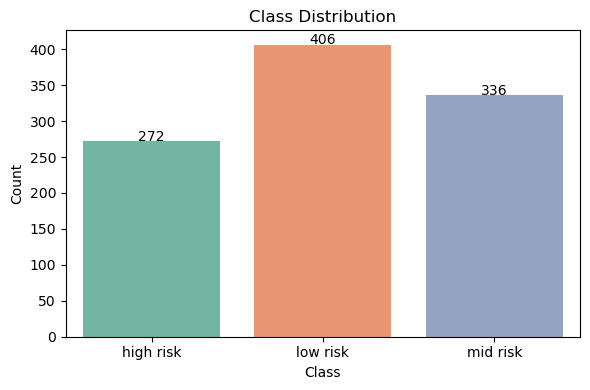

In [19]:
#Class count and Distribution 
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='RiskLevel', palette='Set2')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1,f'{int(height)}', ha="center", fontsize=10, color="black" )
plt.tight_layout()
plt.show()


# Comments
1. low risk has the highest count, followed by mid risk and high risk has a lowest count

********

# Checking for Duplicated Values 

In [23]:
# Check for Duplicates
dups = df[df.duplicated()]
print(f"\nNumber of duplicated rows: {len(dups)}")
if not dups.empty:
    print("Sample duplicated rows:")
    print(dups.head())



Number of duplicated rows: 562
Sample duplicated rows:
     Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
67    19         120           80   7.0      98.0         70   mid risk
72    19         120           80   7.0      98.0         70   mid risk
97    19         120           80   7.0      98.0         70   mid risk
106   50         140           90  15.0      98.0         90  high risk
107   25         140          100   6.8      98.0         80  high risk


# Comments
1. Duplication in a dataset can cause bias and subsequently cause overfitting
2. In this case 562 duplicates is alot compared to the total number of rows(1014)
3. It might be better to drop the duplicates and leave only the first one using (df = df.drop_duplicates())
4. However, in this case i will leave the duplicated values and first explore the dataset because the dataset is already limited.

*********

# Encoding

In [30]:
# Encode Target Variable before correlation matrix
labelEncoder = LabelEncoder()
df['RiskLevel'] = labelEncoder.fit_transform(df['RiskLevel'])
df.head(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,0
1,35,140,90,13.00,98.0,70,0
2,29,90,70,8.00,100.0,80,0
3,30,140,85,7.00,98.0,70,0
4,35,120,60,6.10,98.0,76,1
5,23,140,80,7.01,98.0,70,0
6,23,130,70,7.01,98.0,78,2
7,35,85,60,11.00,102.0,86,0
8,32,120,90,6.90,98.0,70,2
9,42,130,80,18.00,98.0,70,0


In [31]:
labels_dict={"high risk":0,"low risk":1,"mid risk":2}
labels_dict

{'high risk': 0, 'low risk': 1, 'mid risk': 2}

# comments 
1. The target variable (RiskLevel) is categorical and should be encoded for easy processing
2. I have stored the labels in a dictionary so that i can easily locate them. 

***********

# Correlation HeatMap

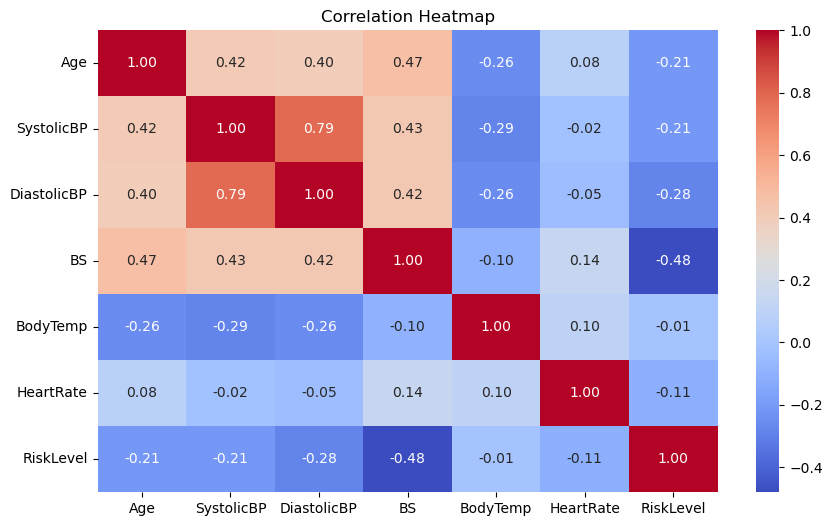

In [39]:
# Correlation Heatmap
feature_cols = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp","HeartRate"] 
plt.figure(figsize=(10, 6))
corr = df[feature_cols + ['RiskLevel']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Comments
1. SystolicBP and  DiastolicBP have a high strong correlation with correlation coeffiecient of 0.79. It means that as one increases, the other also increases hence the assumption that SystolicBP and  DiastolicBP are providing simIlar information trends.(Multicolinearity)
2. Multicolinearity makes it hard to estimate the effect of the individual variable on the target.
3. because they provide the same information, it might be better to drop one.
4. However, just like mentioned before the dataset is quite limited and carrying out further analysis before dropping any of them is important.


**************************

# Multivariate Analysis:Correlation Between Variables

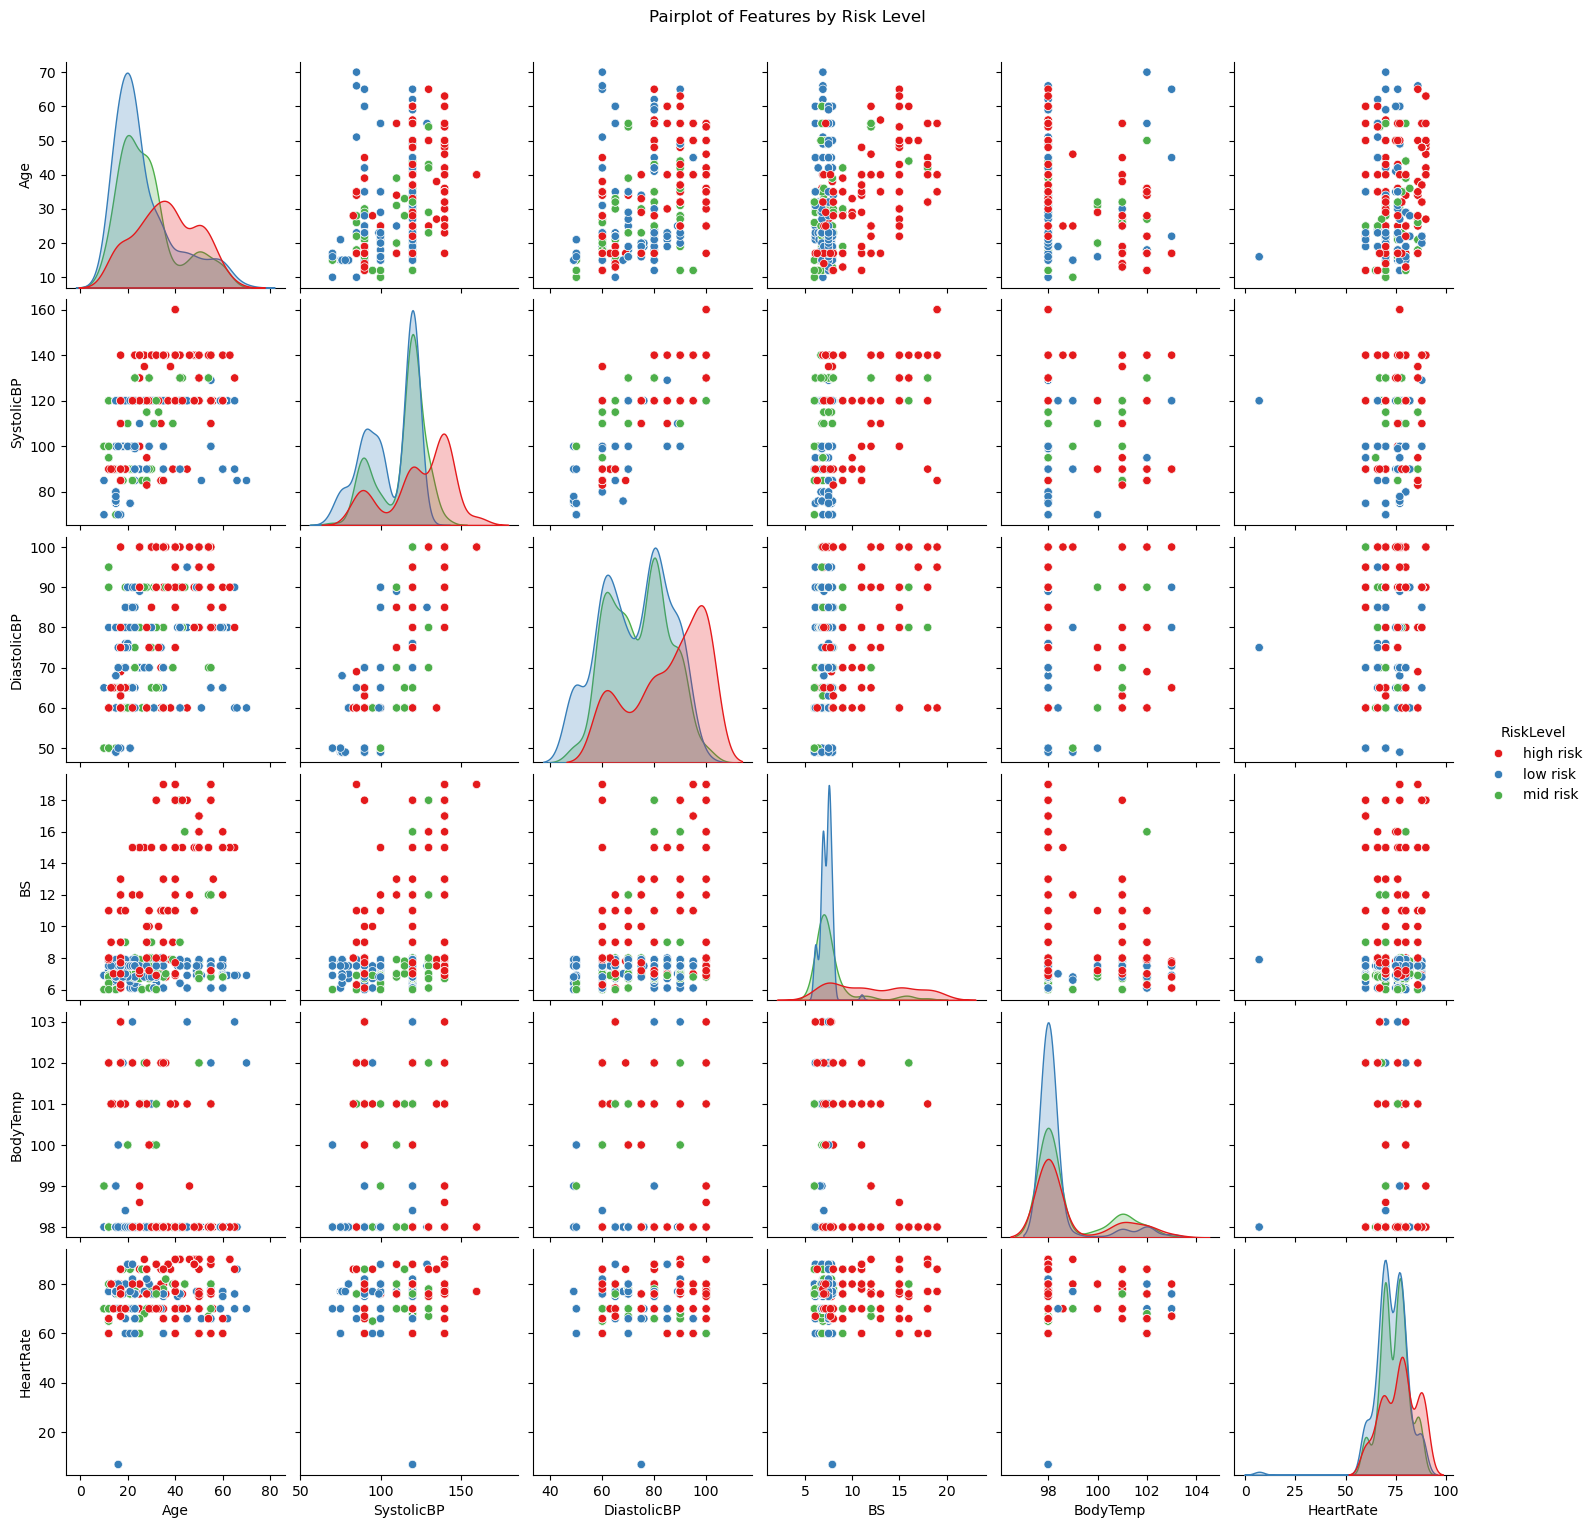

In [44]:
# Pairplot to Explore Variable Relationships
df_viz = df.copy()
df_viz['RiskLevel'] = labelEncoder.inverse_transform(df['RiskLevel'])
sns.pairplot(df_viz, hue="RiskLevel", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot of Features by Risk Level", y=1.02)
plt.show()

# Observations
1. HeartRate seems to have little or no influence on the distribution of the target classes regardardless of the varaiables.
2. Dropping HeartRate completely might be considered since it doesn't contribute significantly to the class distribution.However, further exploration      will be done to come to an informed decision. 
3. There is a clear outlier indicated for the HeartRate varaiable and that should be looked at.
4. There is a clear oulier indicated for the the SystolicBP variable and that should also be looked at.

# Multivariate analysis with Age
1. Younger women with Lower BodyTemp generally have lower risk and Young women with high BodyTemp generally have higher risk.However,older women with      high BodyTemp have low risk while old women with low BodyTemp have high risk
2. Old women with low BS have low risk but generally, both young and old women have high risk as the BS increases
3. Both young and old women have high risk as the DiastolicBP increases.
4. Both young and old women have high risk as the SystolicBP increases.

# Multivariate analysis with SystolicBP
1. Women with lower BodyTemp and lower SystolicBP have lower risk however,women with high SystolicBP are generally at high risk regardless of their BodyTemp.
2. Women with lower BS and low SystolicBP have lower risks however as the SystolicBP increases and the BS increases, the RiskLevel also increaes.
3. It is still evident that the correlation between SystolicBP and DiastolicBP is high and the RiskLevel increases as both increase.  

# Multivariate analysis with DiastolicBP
1. There is a clear outlier for the low risk class and should be considered to be removed if it doesnt carry so much information.
2. Women with low DiastolicBP and low BodyTemp, BS, SystolicBP and Age are generally at lower risk. However from 60 mmHg upwards, the RiskLevel increases as the DiastolicBP increseases regardless of the other variable.

# Multivariate analysis with BS
1. Women with a low BodyTemp have high risk regardless of their BS Levels.
2. Generally, women with high BS Levels have a high risk.
3. Also women with low BS but older age have lower risk.

******************

# Multivariate Analysis:Average Feature Values per Risk Level

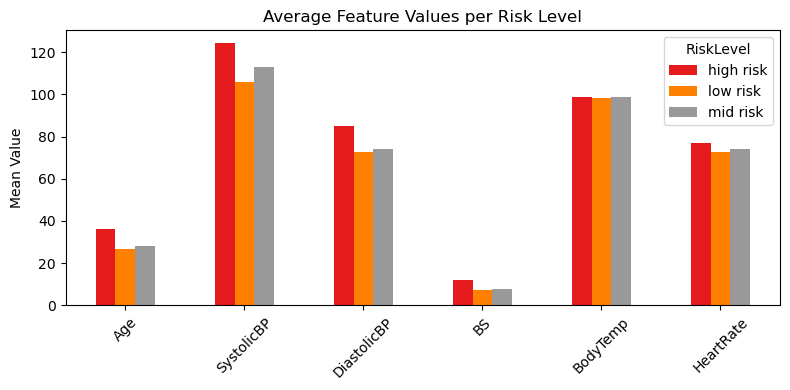

In [48]:
# Average Feature Values per Risk Level
grouped = df_viz.groupby('RiskLevel')[feature_cols].mean().T
grouped.plot(kind='bar', figsize=(8, 4), colormap='Set1')
plt.title("Average Feature Values per Risk Level")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**************************

# Univariate Analysis

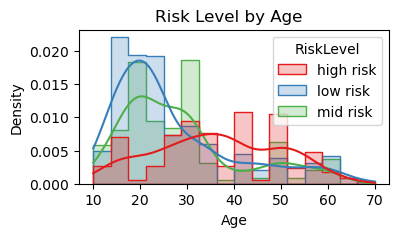

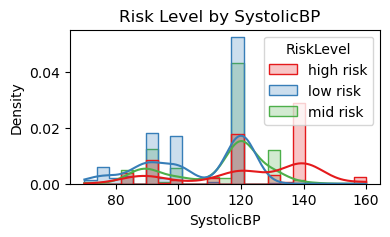

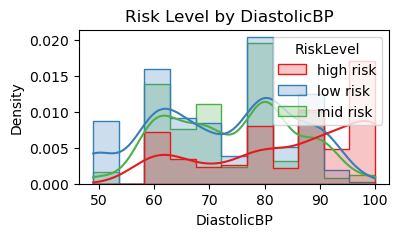

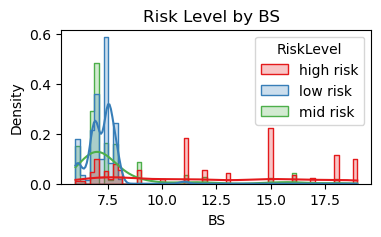

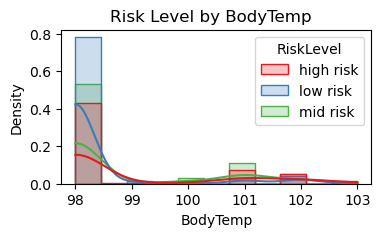

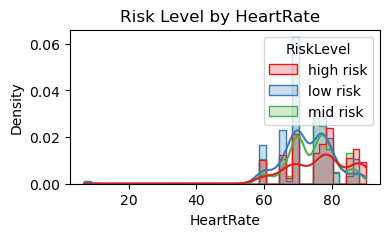

In [51]:
#  Distribution by Risk Level
for col in feature_cols:
    plt.figure(figsize=(4, 2))
    sns.histplot(data=df_viz, x=col, hue="RiskLevel", kde=True, palette="Set1", element="step", stat="density")
    plt.title(f"Risk Level by {col}  ")
    plt.show()

**********************

# Outlier Analysis

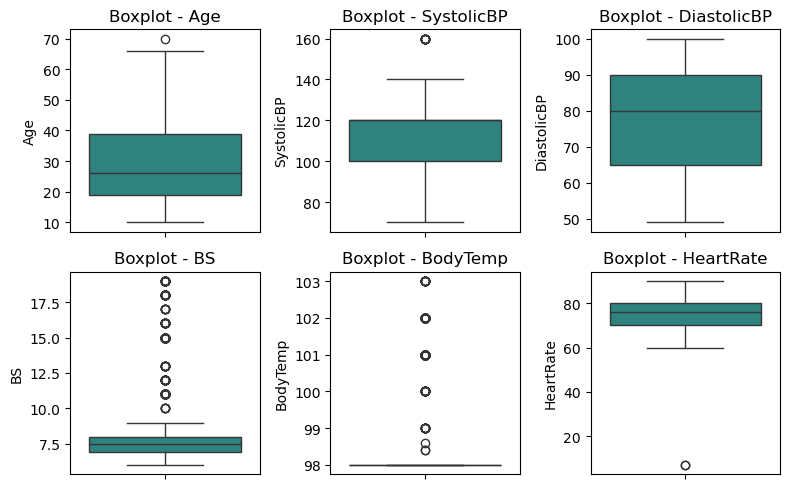

In [54]:
# Visualize Outliers with Boxplots
feature_cols = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp","HeartRate"] 
plt.figure(figsize=(8, 5))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col, palette="viridis")
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

# Comments
1. As earlier discovered in the pairsplot, there is a clear outlier that is way out range for the HeartRate varaible and SystolicBP variable. 
2. I will be dropping the outliers from HeartRate and SystolicBP.
3. The other variables also have outliers but they dont seem to be way over the range of values. I will leave them for now since the dataset is quite limited. But it is worth noting that outliers may skew distributions,cause overfitting and generally mislead results.


******************

# Removing the prominent outliers 

In [58]:
# Define the columns to remove outliers from
columns_to_clean = ['HeartRate', 'SystolicBP']

# Loop through each column and apply the IQR method
for col in columns_to_clean:
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                # Interquartile range

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only rows within the bounds
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


In [59]:
df.count()

Age            1002
SystolicBP     1002
DiastolicBP    1002
BS             1002
BodyTemp       1002
HeartRate      1002
RiskLevel      1002
dtype: int64

# Comments
1. we now have 1002 rows after dropping the outliers from HeartRate and SystolicBP.

********************

# Pre Processing 

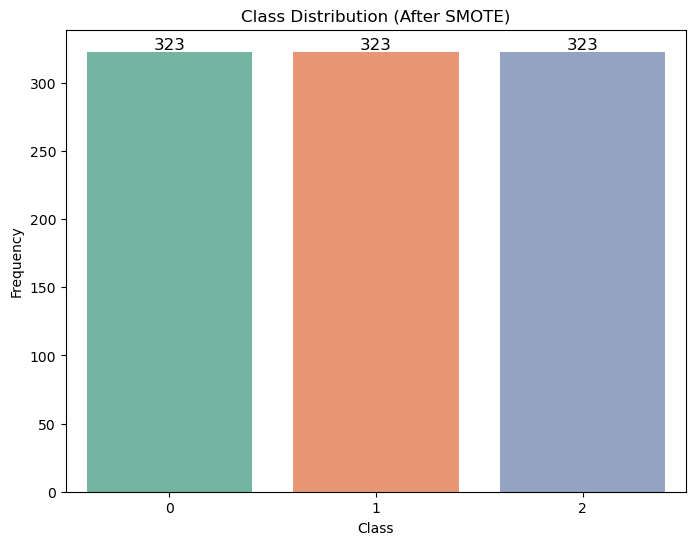

In [63]:
# Define Features & Target
X = df[feature_cols]
y = df['RiskLevel']

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to Balance Classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Show Class Distribution After SMOTE with Total Counts
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_train_smote,palette='Set2')
plt.title("Class Distribution (After SMOTE)")
plt.xlabel("Class")
plt.ylabel("Frequency")


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

# Comments 
1. Encoding:The target variable has been encoded to convert categorical values into numerical format, making it suitable for machine learning algorithms.

2. Scaling:
The predictor variables have been scaled to ensure that all features contribute equally to the learning process. This prevents variables with larger magnitudes from disproportionately influencing the model.

3. Splitting:
The dataset is split into training and testing sets using an 80/20 ratio. This allows the model to learn from one portion of the data and be evaluated on unseen data to assess its performance.

4. SMOTE (Synthetic Minority Over-sampling Technique):
SMOTE is applied to the training data to address class imbalance, which was identified earlier. This technique generates synthetic examples for the minority class, improving the model's ability to learn from imbalanced datasets.

**************************

# Training the models 

In [67]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=1),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

# Train & Evaluate Models
accuracy_results = []
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_train_pred = model.predict(X_train_smote)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train_smote, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
        print(f"{model_name}: AUC Score = {auc_score:.4f}")
    else:
        auc_score = None
        print(f"{model_name}: AUC Score not available")

    accuracy_results.append((model_name, train_acc, test_acc, auc_score))
    print(f"{model_name}: Training Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))

Logistic Regression: AUC Score = 0.7617
Logistic Regression: Training Accuracy = 0.6109, Test Accuracy = 0.5473
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        53
           1       0.57      0.59      0.58        81
           2       0.42      0.33      0.37        67

    accuracy                           0.55       201
   macro avg       0.54      0.56      0.54       201
weighted avg       0.53      0.55      0.54       201

Random Forest: AUC Score = 0.9355
Random Forest: Training Accuracy = 0.9474, Test Accuracy = 0.8010
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        53
           1       0.85      0.75      0.80        81
           2       0.69      0.85      0.76        67

    accuracy                           0.80       201
   macro avg       0.82      0.81      0.81       201
weighted avg       0.82      0.80      0.80       201

Naive Bayes: AUC Score = 0

**********************

In [69]:
# Model Comparison Table
df_results = pd.DataFrame(accuracy_results, columns=["Model", "Training Accuracy", "Test Accuracy", "AUC Score"])
df_results_sorted = df_results.sort_values(by="Test Accuracy", ascending=False)
print("\nModel Comparison Table:")
df_results_sorted


Model Comparison Table:


,Model,Training Accuracy,Test Accuracy,AUC Score
1,Random Forest,0.947368,0.800995,0.935475
6,XGBoost,0.947368,0.796020,0.946130
4,Decision Tree,0.947368,0.771144,0.888204
5,KNN,0.915377,0.761194,0.812615
3,SVM,0.731682,0.606965,0.794991
2,Naive Bayes,0.622291,0.572139,0.763896
0,Logistic Regression,0.610939,0.547264,0.761693


# Comments:
1. The highest training accuracy was observed across all three models — Random Forest, XGBoost, and Decision Tree — at 94.7%,indicating that the models fit the training data very well.

2. The highest AUC score was achieved by XGBoost (0.9461), suggesting it is the most effective at distinguishing between classes.

3. In terms of test accuracy, Random Forest performed best with 80.1%, followed closely by XGBoost. 
   However, the consistent 94.7% training accuracy across models, coupled with a drop in test accuracy (especially for Decision Tree), 
   may indicate overfitting — where the models perform exceptionally well on training data but not as well on unseen data.

4. To address this,cross-validation (Stratified 5-Fold Cross-Validation) will be applied to  to assess model generalizability and ensure that the performance is stable across different subsets of the data.

*******************

 # Stratified 5-Fold Cross-Validation

In [73]:
# Apply Stratified 5-Fold Cross-Validation
kf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results_5 = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf_5, scoring="accuracy")
    mean_acc = scores.mean()
    cv_results_5.append((model_name, mean_acc))
    print(f"{model_name}: Mean Accuracy (5-Fold CV) = {mean_acc:.4f}")

df_results_cv_5 = pd.DataFrame(cv_results_5, columns=["Model", "Mean Accuracy"])
df_results_cv_sorted_5 = df_results_cv_5.sort_values(by="Mean Accuracy", ascending=False)
print("\n Model Comparison Table (5-Fold CV):")
df_results_cv_sorted_5

Logistic Regression: Mean Accuracy (5-Fold CV) = 0.6137
Random Forest: Mean Accuracy (5-Fold CV) = 0.8573
Naive Bayes: Mean Accuracy (5-Fold CV) = 0.5948
SVM: Mean Accuracy (5-Fold CV) = 0.7026
Decision Tree: Mean Accuracy (5-Fold CV) = 0.8393
KNN: Mean Accuracy (5-Fold CV) = 0.8503
XGBoost: Mean Accuracy (5-Fold CV) = 0.8503

 Model Comparison Table (5-Fold CV):


,Model,Mean Accuracy
1,Random Forest,0.857323
6,XGBoost,0.850343
5,KNN,0.850333
4,Decision Tree,0.839343
3,SVM,0.702607
0,Logistic Regression,0.613726
2,Naive Bayes,0.594806


# Comments:
1. Applying Stratified 5-Fold Cross-Validation, the test accuracy increases from 80.10% (single split for Random Forest) to 85.73% 
   (mean cross-validation accuracy for Random Forest).

2. XGBoost also benefits, with test accuracy improving from 79.60% (single split) to 85.03% (cross-validation mean).

3. For KNN, the test accuracy improves from 76.12% (single split) to 85.03% (cross-validation mean), and similarly, 
   Decision Tree sees an increase from 77.11% to 83.93%.

4. The significant increase in test accuracy after cross-validation indicates that the models generalize better and the risk of overfitting is reduced.

****************************

# Stratified 10-Fold Cross-Validation

In [77]:
# Apply Stratified 10-Fold Cross-Validation
kf_10= StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_10 = []
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf_10, scoring="accuracy")
    mean_acc = scores.mean()
    cv_results_10.append((model_name, mean_acc))
    print(f"{model_name}: Mean Accuracy (10-Fold CV) = {mean_acc:.4f}")

df_results_cv_10 = pd.DataFrame(cv_results_10, columns=["Model", "Mean Accuracy"])
df_results_cv_10_sorted = df_results_cv_10.sort_values(by="Mean Accuracy", ascending=False)
print("\n Model Comparison Table (10-Fold CV):")
df_results_cv_10_sorted

Logistic Regression: Mean Accuracy (10-Fold CV) = 0.6158
Random Forest: Mean Accuracy (10-Fold CV) = 0.8554
Naive Bayes: Mean Accuracy (10-Fold CV) = 0.5959
SVM: Mean Accuracy (10-Fold CV) = 0.6997
Decision Tree: Mean Accuracy (10-Fold CV) = 0.8503
KNN: Mean Accuracy (10-Fold CV) = 0.8474
XGBoost: Mean Accuracy (10-Fold CV) = 0.8573

 Model Comparison Table (10-Fold CV):


,Model,Mean Accuracy
6,XGBoost,0.857337
1,Random Forest,0.855356
4,Decision Tree,0.850337
5,KNN,0.847356
3,SVM,0.699683
0,Logistic Regression,0.615802
2,Naive Bayes,0.595851


# Comment:
1. Applying Stratified 10-Fold Cross-Validation show minimal change from the 5-fold, suggesting that increasing the number of folds from 5 to 10 does not significantly impact the models accuracy but just cause a small change.
   
3. XGBoost has now the highest accuracy at 85.73%, while Random Forest follows closely at 85.54%.
   
5. So far, these are our highest performing models. 

***************

# Feature Importance

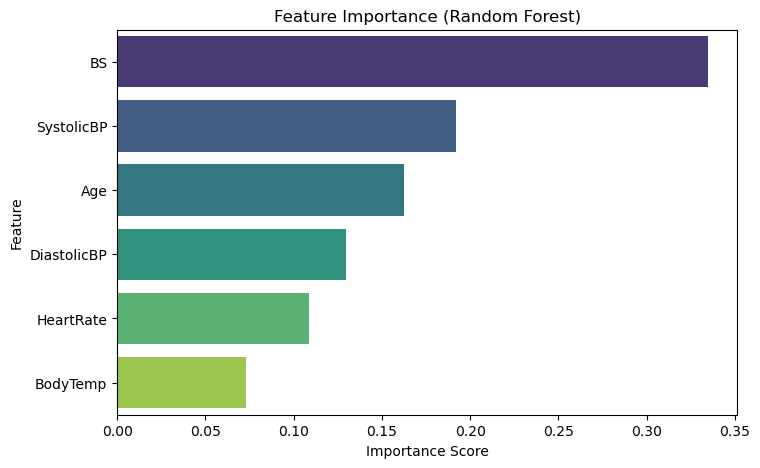

In [83]:
# using Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_smote, y_train_smote)
importances = random_forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.show()

# Comments:
1. With feature importance, we are trying to understand if some features are as significant to the model or if they should be dropped. 
2. So far, i think i will keep all the features and explore hyperparameter tuning to further improve the perfomance of the model. 
3. It should be noted that since this is sensitive topic and could mean life or death, it is important that the accuracy and robustness 
   of the model is very good.(Above 90%)


******************

# Hyperparameter Tuning

In [87]:
# Defining parameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 200, 300]
    },
    "Random Forest": {
        'n_estimators': [50,100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "KNN": {
        'n_neighbors': [1, 5, 10, 15],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}


In [89]:

# Initialize a dictionary to store the best models, AUC scores, and cross-validation results
best_models = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    print(f"Hyperparameter tuning for {model_name}...")
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grids[model_name], cv=10, n_jobs=-1, verbose=1, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Perform 5-fold cross-validation for accuracy
    cv_accuracy = cross_val_score(best_model, X_train_smote, y_train_smote, cv=10, scoring='accuracy')
    mean_accuracy = cv_accuracy.mean()

    # Perform AUC score calculation (for classification models)
    best_model.fit(X_train_smote, y_train_smote)
    y_pred_prob = best_model.predict_proba(X_test)  
    auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')  
    
    # Store the results
    best_models[model_name] = {
        "Best Model": best_model,
        "Best Params": best_params,
        "Mean Accuracy (10-Fold CV)": mean_accuracy,
        "AUC Score": auc_score
    }
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Mean Accuracy (10-Fold CV) for {model_name}: {mean_accuracy}")
    print(f"AUC Score for {model_name}: {auc_score}")
    print("-" * 50)

for model_name, result in best_models.items():
    print(f"{model_name} - Best AUC Score: {result['AUC Score']}, Mean Accuracy: {result['Mean Accuracy (10-Fold CV)']}")


Hyperparameter tuning for Logistic Regression...
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Mean Accuracy (10-Fold CV) for Logistic Regression: 0.6170854810996563
AUC Score for Logistic Regression: 0.7759319643961078
--------------------------------------------------
Hyperparameter tuning for Random Forest...
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Accuracy (10-Fold CV) for Random Forest: 0.8668170103092784
AUC Score for Random Forest: 0.9336727365035284
--------------------------------------------------
Hyperparameter tuning for Naive Bayes...
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Mean Accuracy (10-Fold CV) for Naive Bayes: 0.6139926975945017
AUC S

*****************

# Application of the hyperparameter tuning 

In [95]:
# Dictionary of models with tuned hyperparameters
models_2 = {
    "Logistic Regression": LogisticRegression(C=0.1, max_iter=100, solver='liblinear'),
    "Random Forest": RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42),
    "Naive Bayes": GaussianNB(var_smoothing=1e-09),
    "SVM": SVC(C=10, gamma='auto', kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42),
    "KNN": KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='uniform'),
    "XGBoost": xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8, use_label_encoder=False, 
                                 eval_metric='mlogloss', random_state=42)
}

# Initialize result lists
results = []

# Loop through models and evaluate
for name, model in models_2.items():
    # Fit model on training data
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on training and test data
    y_train_pred = model.predict(X_train_smote)
    y_test_pred = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train_smote, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # AUC score (handle models without predict_proba)
    try:
        y_test_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
    except:
        auc = np.nan  # Not available for this model
    
    # 10-Fold Cross Validation on training data
    cv_acc = cross_val_score(model, X_train_smote, y_train_smote, cv=10, scoring='accuracy').mean()
    
    # Append results
    results.append({
        'Model': name,
        'Training Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'AUC Score': round(auc, 4) if not np.isnan(auc) else 'N/A',
        'CV Accuracy (10-Fold)': round(cv_acc, 4)
    })

# Convert to DataFrame
df_final_results = pd.DataFrame(results)
df_final_results.sort_values(by='CV Accuracy (10-Fold)', ascending=False, inplace=True)

# Display result table
print("\n Model Comparison Table with hyperparameter tuning and 10-Fold CV:")
df_final_results



 Model Comparison Table with hyperparameter tuning and 10-Fold CV:


,Model,Training Accuracy,Test Accuracy,AUC Score,CV Accuracy (10-Fold)
1,Random Forest,0.9474,0.7960,0.9337,0.8668
6,XGBoost,0.9463,0.8010,0.9448,0.8617
4,Decision Tree,0.9474,0.7711,0.8882,0.8493
3,SVM,0.7637,0.6418,0.8285,0.7265
5,KNN,0.7399,0.6567,0.8161,0.7007
0,Logistic Regression,0.6223,0.5572,0.7759,0.6171
2,Naive Bayes,0.6223,0.5721,0.7639,0.6140


# Comments:
1. With the application of the hyperparameter tuning and Stratified 10-Fold Cross-Validation, Random Forest achieved the highest
   10-Fold CV accuracy at 86.68%, followed closely by XGBoost at 86.17%.
2. The 10-Fold Cross-Validation accuracy represents the average testing accuracy across 10 different validation sets. It provides a more robust and reliable estimate of the model's performance on unseen data, compared to accuracy from a single train-test split.
3. AUC scores remained high for both models — 0.9337 for Random Forest and 0.9448 for XGBoost — confirming strong class separation ability and consistent predictive power.
3. What if we wanted to have even a better model with better perfomance? We could consider applying ensembling techniques by combining the best performing models and leveraging their strengths and maximize the predictive power, resulting in a more robust and accurate final model.

************************

# Voting Classifier

Voting Classifier AUC (Training): 0.9925
Voting Classifier AUC (Test): 0.9420
Voting Classifier Accuracy (Training): 0.9474
Voting Classifier Accuracy (Test): 0.8010
Average AUC score (10-fold CV): 0.9512
Average Training Accuracy (10-fold CV): 0.8545
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        53
           1       0.84      0.75      0.79        81
           2       0.70      0.85      0.77        67

    accuracy                           0.80       201
   macro avg       0.82      0.81      0.81       201
weighted avg       0.81      0.80      0.80       201



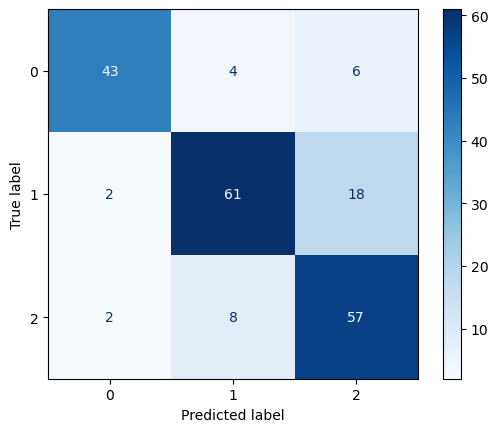

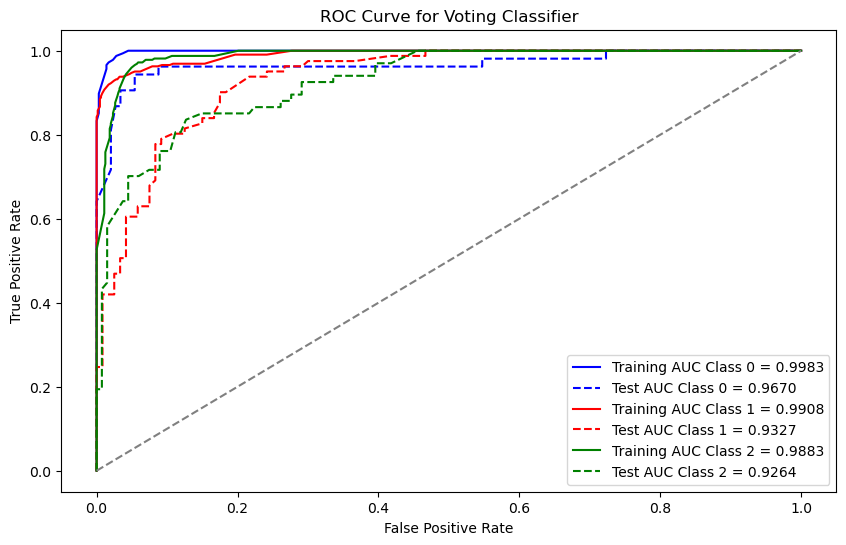

In [100]:
# Define Voting Classifier with top-performing models (using 'soft' voting for classification)
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8, use_label_encoder=False, 
                                 eval_metric='mlogloss', random_state=42)),
    ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='uniform')),
    ('dt', DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42))   
], voting='soft')  

# Train the Voting Classifier (soft voting)
voting_clf.fit(X_train_smote, y_train_smote)

# Evaluate the Voting Classifier (soft voting for classification)
voting_train_pred = voting_clf.predict(X_train_smote)
voting_test_pred = voting_clf.predict(X_test)

# Calculate Accuracies for the entire Voting Classifier
voting_train_acc = accuracy_score(y_train_smote, voting_train_pred)
voting_test_acc = accuracy_score(y_test, voting_test_pred)

# Now calculate AUC for the entire Voting Classifier (using 'predict_proba' for soft voting)
voting_train_auc = roc_auc_score(y_train_smote, voting_clf.predict_proba(X_train_smote), multi_class='ovr')
voting_test_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test), multi_class='ovr')

# Print the AUC and Accuracy for the Voting Classifier as a whole
print(f"Voting Classifier AUC (Training): {voting_train_auc:.4f}")
print(f"Voting Classifier AUC (Test): {voting_test_auc:.4f}")
print(f"Voting Classifier Accuracy (Training): {voting_train_acc:.4f}")
print(f"Voting Classifier Accuracy (Test): {voting_test_acc:.4f}")

# 10-Fold Cross Validation for AUC and Accuracy (using the whole Voting Classifier)
CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
CV_train_auc = cross_val_score(voting_clf, X_train_smote, y_train_smote, cv=CV, scoring='roc_auc_ovr', n_jobs=-1)
CV_train_acc = cross_val_score(voting_clf, X_train_smote, y_train_smote, cv=CV, scoring='accuracy', n_jobs=-1)

# Print the results for 10-fold CV for the entire Voting Classifier
print(f"Average AUC score (10-fold CV): {np.mean(CV_train_auc):.4f}")
print(f"Average Training Accuracy (10-fold CV): {np.mean(CV_train_acc):.4f}")

# Print classification report for the Voting Classifier
print(classification_report(y_test, voting_test_pred))


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, voting_test_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
cmd.plot(cmap='Blues', values_format='d')

# For multi-class classification, we'll binarize the labels and calculate the AUC per class
y_train_bin = label_binarize(y_train_smote, classes=[0, 1, 2])  # Adjust classes as needed
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes as needed

# Calculate ROC curve and AUC for each class in the training set
fpr_train, tpr_train, roc_auc_train = {}, {}, {}
for i in range(y_train_bin.shape[1]):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], voting_clf.predict_proba(X_train_smote)[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])  # Changed 'auc' to 'roc_auc_train[i]'

# Calculate ROC curve and AUC for each class in the test set
fpr_test, tpr_test, roc_auc_test = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], voting_clf.predict_proba(X_test)[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])  # Changed 'auc' to 'roc_auc_test[i]'

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']  # Adjust color as needed
for i in range(y_train_bin.shape[1]):
    plt.plot(fpr_train[i], tpr_train[i], color=colors[i], label=f'Training AUC Class {i} = {roc_auc_train[i]:.4f}')
    plt.plot(fpr_test[i], tpr_test[i], color=colors[i], linestyle='--', label=f'Test AUC Class {i} = {roc_auc_test[i]:.4f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Classifier')
plt.legend(loc='lower right')
plt.show()



# Comments:
1. This voting classifier utilises an ensemble approach, combining the best performing classifiers to enhance performance:Random Forest Classifier (rf)
   XGBoost Classifier (xgb),K-Nearest Neighbors Classifier (knn) and Decision Tree Classifier (dt)
2. Training AUC (0.9925): The model performs excellently in distinguishing between classes on the training data, with a very high Area Under the Curve (AUC) score, indicating a strong ability to separate the classes.
3. Test AUC (0.9420): The model retains its strong classification ability on unseen data, showing good generalization to new data points.
4. Training Accuracy (0.9474): The model fits the training data very well, with a high accuracy score. However, this may also indicate overfitting if not balanced with test data performance.
5. Test Accuracy (0.8010): The model's performance drops on test data, suggesting overfitting, where the model performs well on training data but struggles to generalize on unseen examples.
6. 10-Fold Cross-Validation:Average AUC (0.9512): Cross-validation confirms the model's ability to generalize well across different subsets of data, with a solid AUC score.Average Training Accuracy (0.8545): The model shows strong accuracy across multiple folds, indicating robustness and consistency in performance.
7. Class 0 (Precision 0.91, Recall 0.81, F1-score 0.86): The model is highly precise in identifying Class 0, though it could improve recall (identifying all instances of Class 0).
8. Class 1 (Precision 0.84, Recall 0.75, F1-score 0.79): The model performs well for Class 1, balancing both precision and recall, though there is some room for improvement in precision.
9. Class 2 (Precision 0.70, Recall 0.85, F1-score 0.77): The model struggles with precision for Class 2, suggesting that while it identifies most instances, it sometimes misclassifies instances as Class 2.

*********

# Stacking Classifier

Average AUC score (10-fold CV): 0.9456
Average Training Accuracy: 0.9395
Average 10-Fold Validation Accuracy: 0.8494
Stacking Classifier Test Accuracy: 0.8159
Stacking Classifier Train Accuracy: 0.9370
              precision    recall  f1-score   support

           0       0.91      0.77      0.84        53
           1       0.86      0.81      0.84        81
           2       0.72      0.85      0.78        67

    accuracy                           0.82       201
   macro avg       0.83      0.81      0.82       201
weighted avg       0.83      0.82      0.82       201



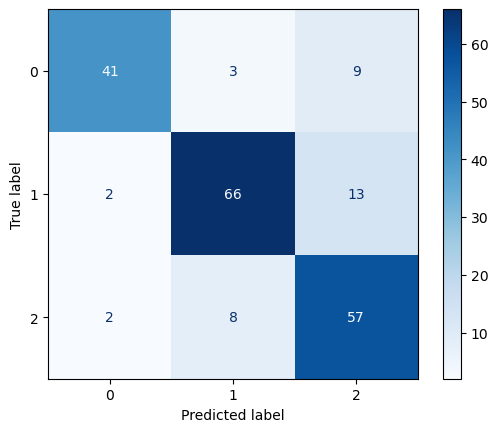

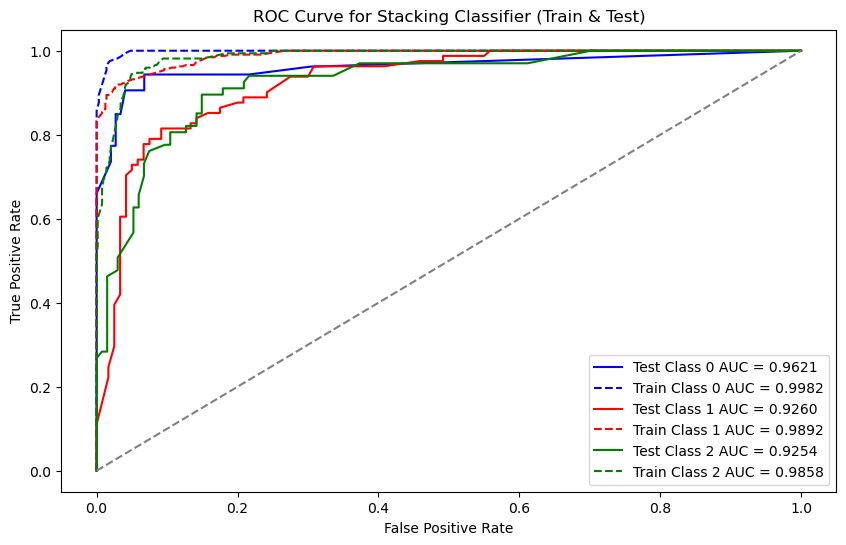

In [106]:

# Base models with tuned hyperparameters
base_estimators = [
    ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8, use_label_encoder=False, 
                                 eval_metric='mlogloss', random_state=42)),
    ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='uniform')),
    ('dt', DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42))  
]

# Initialize the Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier(n_estimators=50, random_state=42))

# Create a Stratified K-Fold cross-validation object (10 folds)
kf_stacking = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store AUC scores for each fold
auc_scores = []
train_accuracies = []
test_accuracies = []

# k-Fold Cross Validation
for train_index, val_index in kf_stacking.split(X_train_smote, y_train_smote):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]
    
    # Fit the model on the current fold
    stacking_clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    train_pred = stacking_clf.predict(X_train_fold)
    val_pred = stacking_clf.predict(X_val_fold)
    
    # Calculate training and validation accuracy for this fold
    train_acc = accuracy_score(y_train_fold, train_pred)
    val_acc = accuracy_score(y_val_fold, val_pred)
    
    # Calculate predicted probabilities for AUC
    val_prob = stacking_clf.predict_proba(X_val_fold)
    
    # If binary classification, use probabilities for the positive class (column 1)
    if len(set(y_val_fold)) == 2:
        auc_score = roc_auc_score(y_val_fold, val_prob[:, 1])
    else:
        # For multiclass, use one-vs-rest AUC
        y_val_bin = label_binarize(y_val_fold, classes=[0, 1, 2])  # Adjust classes as needed
        auc_score = roc_auc_score(y_val_bin, val_prob, average='macro', multi_class='ovr')
    
    # Store the AUC and accuracy for each fold
    auc_scores.append(auc_score)
    train_accuracies.append(train_acc)
    test_accuracies.append(val_acc)

# Calculate the average AUC score, training accuracy, and validation accuracy across all folds
average_auc = np.mean(auc_scores)
average_train_acc = np.mean(train_accuracies)
average_val_acc = np.mean(test_accuracies)

# Print the results
print(f"Average AUC score (10-fold CV): {average_auc:.4f}")
print(f"Average Training Accuracy: {average_train_acc:.4f}")
print(f"Average 10-Fold Validation Accuracy: {average_val_acc:.4f}")

# Finally, train the model on the full training set and evaluate on the test set
stacking_clf.fit(X_train_smote, y_train_smote)
stacking_test_pred = stacking_clf.predict(X_test)
stacking_train_pred = stacking_clf.predict(X_train_smote)

stacking_test_acc = accuracy_score(y_test, stacking_test_pred)
stacking_train_acc = accuracy_score(y_train_smote, stacking_train_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, stacking_test_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_clf.classes_)
cmd.plot(cmap='Blues', values_format='d')

# Print Test Accuracy and Classification Report
print(f"Stacking Classifier Test Accuracy: {stacking_test_acc:.4f}")
print(f"Stacking Classifier Train Accuracy: {stacking_train_acc:.4f}")
print(classification_report(y_test, stacking_test_pred))

# ROC Curve and AUC Calculation
# Binarize labels for multiclass classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes as needed
y_train_bin = label_binarize(y_train_smote, classes=[0, 1, 2])  # Adjust classes as needed

# Calculate ROC curve and AUC for each class in the test set
fpr_test, tpr_test, roc_auc_test = {}, {}, {}
fpr_train, tpr_train, roc_auc_train = {}, {}, {}

for i in range(y_test_bin.shape[1]):
    # Test ROC
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], stacking_clf.predict_proba(X_test)[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    
    # Train ROC
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], stacking_clf.predict_proba(X_train_smote)[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plotting the ROC curve for both train and test
plt.figure(figsize=(10, 6))

# Plot ROC curve for each class in the test set
colors = ['blue', 'red', 'green']  # Adjust colors for different classes as needed
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr_test[i], tpr_test[i], color=colors[i], label=f'Test Class {i} AUC = {roc_auc_test[i]:.4f}')
    plt.plot(fpr_train[i], tpr_train[i], color=colors[i], linestyle='--', label=f'Train Class {i} AUC = {roc_auc_train[i]:.4f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Classifier (Train & Test)')
plt.legend(loc='lower right')
plt.show()


# Comments:
1. Ensemble Composition:The model combines Random Forest (rf), XGBoost (xgb), K-Nearest Neighbors (knn), and Decision Tree (dt) classifiers, with a Random Forest meta-model making the final predictions. This ensemble approach leverages the strengths of multiple models to improve performance.
2. AUC Scores:Training AUC (0.9925): The model performs excellently on the training data, showing strong class separation with a very high AUC score. This indicates that the model can effectively distinguish between different classes in the training set.
3. Test AUC (0.9420): The model retains good generalization to unseen data, maintaining a high AUC score. This shows it is able to classify unseen data with reasonable accuracy.
4. Accuracy:Training Accuracy (0.9395): The model fits the training data well, achieving high accuracy. However, this might indicate potential overfitting, as the training accuracy is higher than test accuracy.Test Accuracy (0.8159): The model's performance drops on the test data, which is common when there is overfitting. The drop from the training accuracy suggests that the model struggles to generalize to new, unseen examples.
5. Cross-Validation:Average AUC (0.9456): The model performs consistently well across multiple cross-validation folds, confirming its ability to generalize effectively across various subsets of the data.Average Training Accuracy (0.9395): The model shows robust performance on training data, with stable results across the different cross-validation folds.
6. Average 10-Fold Validation Accuracy (0.8494): While still strong, this slightly lower accuracy compared to training accuracy suggests that the model is not perfectly generalized but still performs well across different subsets.
7. Class-wise Performance:Class 0 (Precision: 0.91, Recall: 0.77, F1-score: 0.84): The model performs very well in precision, meaning it accurately identifies most of the instances of Class 0. However, recall is slightly lower, meaning some Class 0 instances are not being captured.
Class 1 (Precision: 0.86, Recall: 0.81, F1-score: 0.84): The model shows a balanced performance for Class 1, with good precision and recall. However, a slight improvement in precision could reduce misclassifications of other classes as Class 1.
Class 2 (Precision: 0.72, Recall: 0.85, F1-score: 0.78): The model performs well in recall, identifying a high proportion of Class 2 instances. However, the lower precision suggests that many instances are being misclassified as Class 2, which needs to be improved.

*************************

# Random Forest Classifier with hyperparameter tuning and 
# Stratified 10-Fold Cross-Validation

Random Forest - Performance Report
RF-Training Accuracy: 0.9474
RF-Test Accuracy: 0.796
RF-AUC Score: 0.9336727365035284
RF-10-Fold Cross Validation Accuracy: 0.8668

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87        53
           1       0.85      0.74      0.79        81
           2       0.68      0.85      0.75        67

    accuracy                           0.80       201
   macro avg       0.82      0.80      0.80       201
weighted avg       0.81      0.80      0.80       201



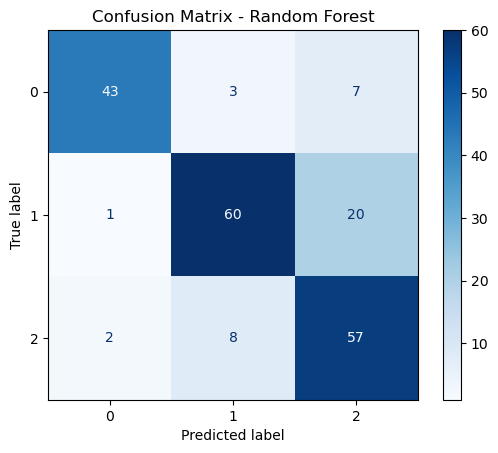

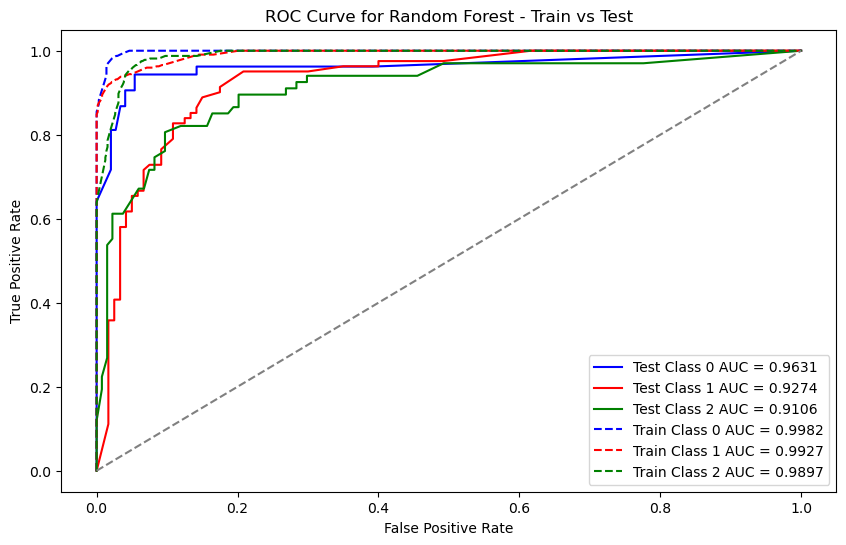

In [110]:


# Predict on test data for Random Forest
rf_pred = models_2['Random Forest'].predict(X_test)

# Accuracy
rf_train_acc = accuracy_score(y_train_smote, models_2['Random Forest'].predict(X_train_smote))
rf_test_acc = accuracy_score(y_test, rf_pred)

# AUC Score (only for models with predict_proba)
try:
    rf_proba = models_2['Random Forest'].predict_proba(X_test)
    rf_auc = roc_auc_score(y_test, rf_proba, multi_class='ovr', average='macro')
except:
    rf_auc = 'N/A'

# 10-Fold Cross Validation on training data
rf_cv_acc = cross_val_score(models_2['Random Forest'], X_train_smote, y_train_smote, cv=10, scoring='accuracy').mean()

# Classification Report
rf_class_report = classification_report(y_test, rf_pred)

# Performance Report
print("Random Forest - Performance Report")

print("RF-Training Accuracy:", round(rf_train_acc, 4))
print("RF-Test Accuracy:", round(rf_test_acc, 4))
print("RF-AUC Score:", rf_auc)
print("RF-10-Fold Cross Validation Accuracy:", round(rf_cv_acc, 4))

# Display classification report
print("\nClassification Report:\n", rf_class_report)

# Plot Confusion Matrix for Random Forest
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Confusion Matrix for Random Forest
plot_confusion_matrix(models_2['Random Forest'], X_test, y_test, 'Random Forest')

# ROC Curve and AUC Calculation
# Binarize labels for multiclass classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes as needed
y_train_bin = label_binarize(y_train_smote, classes=[0, 1, 2])  # Binarize training labels

# Predict probabilities for both train and test datasets
rf_proba_train = models_2['Random Forest'].predict_proba(X_train_smote)

# Calculate ROC curve and AUC for each class in the test set
fpr_test, tpr_test, roc_auc_test = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], rf_proba[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Calculate ROC curve and AUC for each class in the train set
fpr_train, tpr_train, roc_auc_train = {}, {}, {}
for i in range(y_train_bin.shape[1]):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], rf_proba_train[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Plotting the ROC curve for both train and test data
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']  # Adjust colors for different classes as needed

# Plot ROC curve for each class - Test data
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr_test[i], tpr_test[i], color=colors[i], label=f'Test Class {i} AUC = {roc_auc_test[i]:.4f}')

# Plot ROC curve for each class - Train data
for i in range(y_train_bin.shape[1]):
    plt.plot(fpr_train[i], tpr_train[i], color=colors[i], linestyle='--', label=f'Train Class {i} AUC = {roc_auc_train[i]:.4f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest - Train vs Test')
plt.legend(loc='lower right')
plt.show()


***********************

# XGBoost Classifier with hyperparameter tuning and 
# Stratified 10-Fold Cross-Validation

XGBoost - Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.75      0.83        53
           1       0.84      0.80      0.82        81
           2       0.69      0.84      0.76        67

    accuracy                           0.80       201
   macro avg       0.82      0.80      0.80       201
weighted avg       0.82      0.80      0.80       201


XGBoost - AUC Score: 0.9448
XGBoost - Training Accuracy: 0.9463
XGBoost - Testing Accuracy: 0.801
XGBoost - CV Accuracy (10-Fold): 0.8617


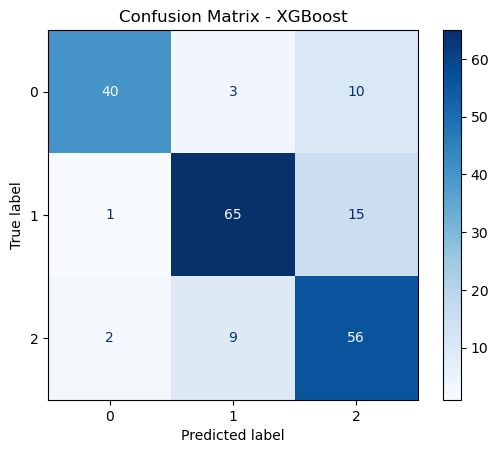

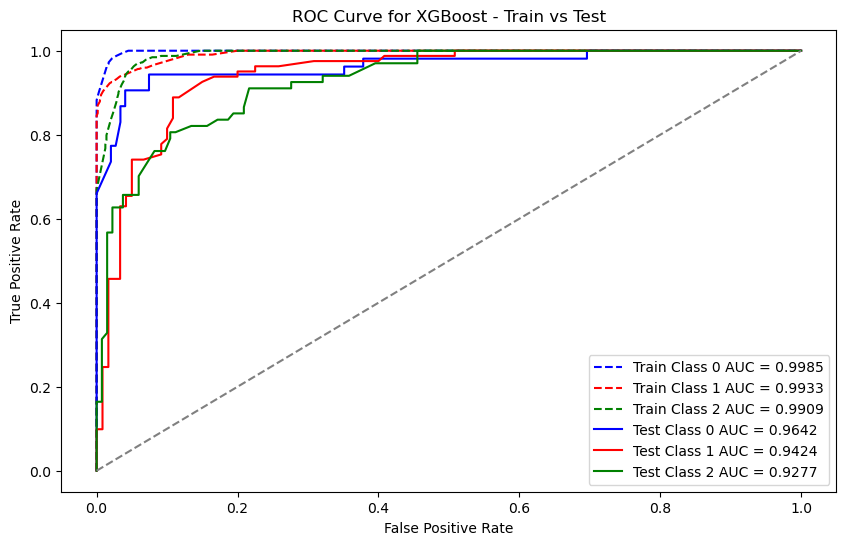

In [114]:


# Predicting on test data for XGBoost
y_test_pred_xgb = models_2['XGBoost'].predict(X_test)

# Generate classification report
xgb_classification_report = classification_report(y_test, y_test_pred_xgb)
print("XGBoost - Classification Report:\n")
print(xgb_classification_report)

# Predicting probabilities for AUC
y_test_proba_xgb = models_2['XGBoost'].predict_proba(X_test)
y_train_proba_xgb = models_2['XGBoost'].predict_proba(X_train_smote)

# AUC Score (multi-class)
auc_xgb = roc_auc_score(y_test, y_test_proba_xgb, multi_class='ovr', average='macro')

# Training accuracy
train_acc_xgb = accuracy_score(y_train_smote, models_2['XGBoost'].predict(X_train_smote))

# Testing accuracy
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

# 10-Fold Cross Validation
cv_acc_xgb = cross_val_score(models_2['XGBoost'], X_train_smote, y_train_smote, cv=10, scoring='accuracy').mean()

# Print performance metrics
print("\nXGBoost - AUC Score:", round(auc_xgb, 4))
print("XGBoost - Training Accuracy:", round(train_acc_xgb, 4))
print("XGBoost - Testing Accuracy:", round(test_acc_xgb, 4))
print("XGBoost - CV Accuracy (10-Fold):", round(cv_acc_xgb, 4))

# Confusion Matrix for XGBoost
plot_confusion_matrix(models_2['XGBoost'], X_test, y_test, 'XGBoost')

# ROC Curve and AUC Calculation for XGBoost - Training Data
y_train_bin_xgb = label_binarize(y_train_smote, classes=[0, 1, 2])  # Adjust classes as needed
fpr_train_xgb, tpr_train_xgb, roc_auc_train_xgb = {}, {}, {}
for i in range(y_train_bin_xgb.shape[1]):
    fpr_train_xgb[i], tpr_train_xgb[i], _ = roc_curve(y_train_bin_xgb[:, i], y_train_proba_xgb[:, i])
    roc_auc_train_xgb[i] = auc(fpr_train_xgb[i], tpr_train_xgb[i])

# ROC Curve and AUC Calculation for XGBoost - Test Data
y_test_bin_xgb = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes as needed
fpr_test_xgb, tpr_test_xgb, roc_auc_test_xgb = {}, {}, {}
for i in range(y_test_bin_xgb.shape[1]):
    fpr_test_xgb[i], tpr_test_xgb[i], _ = roc_curve(y_test_bin_xgb[:, i], y_test_proba_xgb[:, i])
    roc_auc_test_xgb[i] = auc(fpr_test_xgb[i], tpr_test_xgb[i])

# Plotting the ROC curve for both training and test data
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']  # Adjust colors for different classes as needed

# Plot ROC curve for each class - Training data
for i in range(y_train_bin_xgb.shape[1]):
    plt.plot(fpr_train_xgb[i], tpr_train_xgb[i], color=colors[i], linestyle='--', label=f'Train Class {i} AUC = {roc_auc_train_xgb[i]:.4f}')

# Plot ROC curve for each class - Test data
for i in range(y_test_bin_xgb.shape[1]):
    plt.plot(fpr_test_xgb[i], tpr_test_xgb[i], color=colors[i], label=f'Test Class {i} AUC = {roc_auc_test_xgb[i]:.4f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost - Train vs Test')
plt.legend(loc='lower right')
plt.show()


# Final Comments:

Top Performers:
1. Random Forest (RF) and XGBoost did the best, showing strong results in accuracy and AUC.
2. RF reached 86.68% accuracy with hyperparameter tuning and 10-Fold CV.
3. XGBoost was close, with 86.17% accuracy and great class separation (AUC = 0.9448).

Ensemble Models (Voting & Stacking):
1. Voting Classifier and Stacking combined multiple models but didn’t really improve performance much.
2. They had similar test accuracy (80.1%) and AUC scores compared to RF and XGBoost.
3. Overfitting was still a problem with these ensembles (training vs. test performance gap).

Why the Ensembles Didn’t Help Much:
1. RF and XGBoost are already strong models, so combining them with similar models didn’t add much value.
2. Ensembles might not fix overfitting problems; they just aggregate existing models without diversity.

Next Steps for Improvement:
1. Revisit Feature Engineering:Create more domain-specific features or feature interactions (e.g., polynomial features) and implementing feature selection techniques to refine your model inputs. Features like HeartRate that dont give much information could be dropped.
2. Examine Data Quality:The duplicates could be removed and the remaiming outliers could be dealt with to reduce their impact.
3. Model Interpretation:Use SHAP or LIME to interpret model decisions, potentially uncovering useful feature interactions.
4. Boosting with More Models:Consider trying LightGBM or CatBoost alongside XGBoost and RF for better performance.
5. Ensemble Refinement:Experiment with a broader mix of models (e.g., Gradient Boosting, LightGBM, Neural Networks) in your ensemble approach.
